In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [36]:
model = tf.keras.models.load_model('pneumonia_model.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,485,445 (55.26 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,656,964 (36.84 MB)

In [37]:
# The target layer for Grad-CAM
target_layer = "conv2d_2"
test_img_path = "data/chest_xray/test/NORMAL/IM-0010-0001.jpeg"

In [38]:
def get_img_array(img_path, size=(150, 150)):
    # Load image and resize
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # Convert to array
    array = tf.keras.utils.img_to_array(img)
    # Normalize (0 to 1)
    array = array.astype('float32') / 255.0
    # Add batch dimension (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_array = get_img_array(test_img_path)

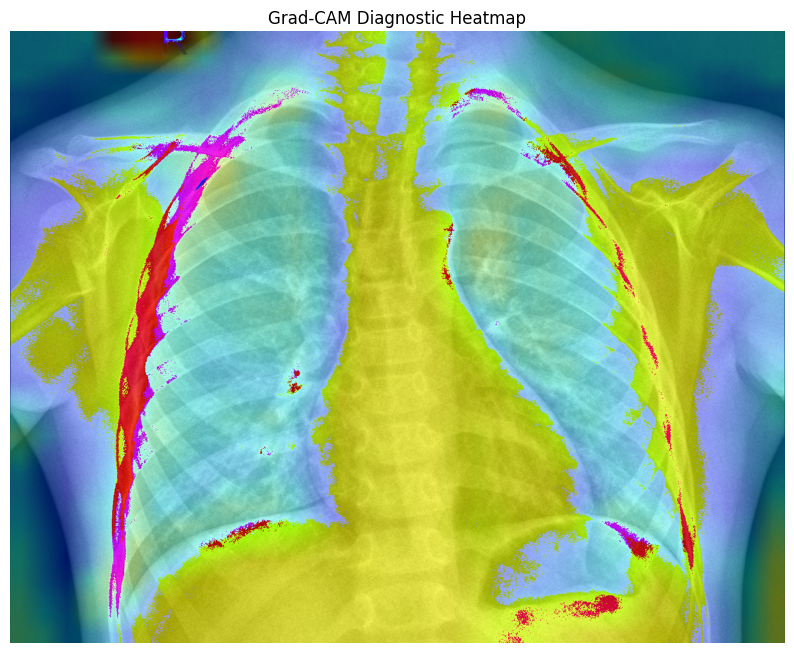

In [39]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # 1. Isolate the two parts of your model
    # Part A: From input to the last conv layer
    # Part B: From the last conv layer to the final prediction
    
    # Get the layer object
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # Create a sub-model that stops at the conv layer
    base_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    
    # Create a second sub-model for the remaining layers (Classifier)
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    # Loop through the remaining layers after the conv layer
    reached_target = False
    for layer in model.layers:
        if reached_target:
            x = layer(x)
        if layer.name == last_conv_layer_name:
            reached_target = True
    
    classifier_model = tf.keras.Model(classifier_input, x)

    # 2. Run the math through the GradientTape
    with tf.GradientTape() as tape:
        # Get activations of the conv layer
        last_conv_layer_output = base_model(img_array)
        tape.watch(last_conv_layer_output) # <--- Force the tape to watch this
        
        # Get final prediction
        preds = classifier_model(last_conv_layer_output)
        top_class_channel = preds[:, 0] # For binary (Pneumonia/Normal), index 0 is the output

    # 3. Calculate the gradients (This shouldn't be None anymore!)
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # 4. Standard Grad-CAM math
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize heatmap to match original image
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Diagnostic Heatmap")
    plt.show()

# --- EXECUTION ---
# Prepare image
img = tf.keras.utils.load_img(test_img_path, target_size=(150, 150))
img_array = tf.keras.utils.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

model(np.zeros((1, 150, 150, 3)))
# Generate and show
heatmap = make_gradcam_heatmap(img_array, model, target_layer)
display_gradcam(test_img_path, heatmap)


<!-- ![Output](assets/NORMAL_Heatmap.png)
![Output](assets/PNEUMONIA_Heatmap.png) -->
| **PNEUMONIA (Infection Detected)** | **NORMAL (Clear Lungs)** |
| :---: | :---: |
| <img src="assets/PNEUMONIA_Heatmap.png" width="350"> | <img src="assets/NORMAL_Heatmap.png" width="350"> 


**Pneumonia**: Intense "hot" spots (red/yellow) over lung lobes. The model detected opacities or consolidations (fluid/pus) in the lungs.  
**Normal**: Weak, dispersed, or non-existent activation. The lungs are clear and well-aerated; the model found no suspicious density.  
**False Positive**: Hot spots on ribs, heart borders, or medical tubes.	The model is "distracted" by artifacts or high-contrast non-lung areas.